# Dependencias y utilidades

En esta sección configuramos:

- Las **dependencias permitidas**: NumPy y librerías estándar.
- La **semilla aleatoria** para reproducibilidad.
- Funciones utilitarias para:
  - medir tiempos (`time_it`),
  - calcular porcentajes servidos (`percent_served`),
  - calcular tiempos de respuesta promedio (`avg_response_time`).

Estas utilidades serán usadas por el simulador y las métricas del Proyecto Escenario 2 (POMDP).


In [ ]:
# =============== SECCIÓN 1 ===============
# Dependencias y utilidades básicas
import numpy as np
import random
import time
from collections import defaultdict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def time_it(fn, *args, **kwargs):
    t0 = time.time()
    res = fn(*args, **kwargs)
    t1 = time.time()
    return res, t1 - t0

def percent_served(served, total):
    return 100 * served / max(total, 1)

def avg_response_time(times):
    return np.mean(times) if len(times) > 0 else float("nan")

print("Sección 1 cargada correctamente.")


Sección 1 cargada correctamente.


#  Definición del modelo POMDP (Escenario 2)

Aquí definimos todos los componentes fundamentales del **POMDP para el data center con 10 servidores**.

###  Estados (por servidor)
Usamos **estados simples**, cada servidor puede estar en:
- `0 = OK`
- `1 = LOADED`
- `2 = FAIL`

###  Acciones
Para simplificar:
- Acciones `0–9`: asignar solicitud al servidor correspondiente.
- Acción `10`: rechazar la solicitud.
- Acción `11`: realizar mantenimiento preventivo.

### Observaciones con error del 30%
El sensor *no siempre reporta el estado real*:
- Probabilidad de acierto: **70%**
- Probabilidad de error: **15% + 15%**

### Dinámica de transición
Modelo probabilístico de fallos y recuperación:
- OK → LOADED → FAIL
- FAIL → OK (pequeña prob.)
- Etc.

Este modelo permite representar la incertidumbre operativa del data center.


In [ ]:
# =============== SECCIÓN 2 ===============
# Definición del modelo POMDP para 10 servidores

N_SERVERS = 10
N_STATES = 3    # OK, LOADED, FAIL
N_ACTIONS = 12  # 10 asignaciones + reject + mantenimiento
N_OBS = 3       # Observación simple: el sensor dice OK/LOADED/FAIL

# ---- 30% de error en observación ----
# Prob O[o|s] (probabilidad de observar "o" estando en estado "s")
O = np.zeros((N_STATES, N_OBS))

for s in range(N_STATES):
    for o in range(N_OBS):
        if o == s:
            O[s, o] = 0.7     # sensor acierta 70%
        else:
            O[s, o] = 0.15    # error distribuido en los demás estados

# ---- Modelo de transición por servidor ----
# T[s][sp] = P(estado_next = sp | estado_actual = s)
T = np.zeros((N_STATES, N_STATES))

# OK = 0, LOADED = 1, FAIL = 2
T[0] = [0.7, 0.25, 0.05]   # OK -> 70% OK, 25% loaded, 5% fail
T[1] = [0.1, 0.75, 0.15]   # LOADED -> 10% OK, 75% loaded, 15% fail
T[2] = [0.2, 0.0, 0.8]     # FAIL -> 20% OK, 0% loaded, 80% fail

print("Sección 2 cargada correctamente (POMDP definido).")


Sección 2 cargada correctamente (POMDP definido).


# Belief Update con Bayes

El POMDP no conoce los estados reales de los servidores; por eso mantiene
**belief states**, que son distribuciones de probabilidad sobre los estados.

Cada servidor tiene:


b = [P(OK), P(LOADED), P(FAIL)]



### Actualización del belief
Cuando se ejecuta una acción y se observa un resultado ruidoso del sensor,
actualizamos el belief usando:

$$
b'(s') \propto P(o|s') \sum_s P(s'|s, a) \, b(s)
$$

Esto permite que el sistema opere bajo incertidumbre (observabilidad parcial),
tal como exige el Escenario 2.


In [ ]:
# =============== SECCIÓN 3 ===============
# Belief update por servidor (Bayes)

def belief_update_single(b, action, observation):
    """
    b: belief previo del servidor (vector de 3)
    action: acción tomada (no afecta observación en este modelo simple)
    observation: o ∈ {0,1,2}
    """
    b_pred = T.T @ b  # predicción del estado siguiente
    b_new = O[:, observation] * b_pred
    s = np.sum(b_new)
    if s == 0:
        return np.ones(3) / 3
    return b_new / s

print("Sección 3 cargada (belief update listo).")


Sección 3 cargada (belief update listo).


# Value Iteration aproximado sobre beliefs

El espacio de beliefs es **continuo**, por lo que no podemos hacer Value Iteration exacto.

### Solución: discretización del espacio de beliefs
Creamos un conjunto finito de belief vectors muestreados.

### Value iteration sobre estos beliefs
Para cada belief:
- calculamos las recompensas esperadas,
- aplicamos transición de belief,
- integramos la observación con error,
- tomamos el máximo sobre acciones.

Esto produce una aproximación de la política óptima bajo observabilidad parcial,
lo cual es la esencia del componente **POMDP (25%)** del proyecto.


In [ ]:
# =============== SECCIÓN 4 ===============
# Value Iteration aproximado sobre un conjunto discreto de beliefs

def generate_belief_grid():
    """
    Muestrea beliefs discretos sobre simplex 3D para cada servidor.
    """
    beliefs = []
    grid = [0.0, 0.5, 1.0]

    for p0 in grid:
        for p1 in grid:
            p2 = 1 - p0 - p1
            if p2 >= 0:
                beliefs.append(np.array([p0, p1, p2]))
    return beliefs

BELIEF_SET = generate_belief_grid()

def pomdp_value_iteration(belief_set, gamma=0.9, theta=1e-4, max_iters=50):
    nB = len(belief_set)
    V = np.zeros(nB)

    for it in range(max_iters):
        delta = 0
        V_new = np.zeros_like(V)

        for i, b in enumerate(belief_set):
            q_values = []

            for a in range(N_ACTIONS):
                # Recompensa esperada por asignar a servidor elegido
                if a < N_SERVERS:
                    # Si el servidor está OK o LOADED servirá bien
                    r = 1.0*b[0] + 0.5*b[1] - 1.0*b[2]
                else:
                    r = 0

                expected_future = 0
                for o in range(N_OBS):
                    b_next = belief_update_single(b, a, o)
                    # buscamos belief más cercano
                    dists = [np.linalg.norm(b_next - bb) for bb in belief_set]
                    j = np.argmin(dists)
                    expected_future += (1/N_OBS) * V[j]

                q_values.append(r + gamma * expected_future)

            V_new[i] = max(q_values)
            delta = max(delta, abs(V_new[i] - V[i]))

        V = V_new
        if delta < theta:
            break

    return V

print("Sección 4 cargada (Value Iteration aproximado listo).")


Sección 4 cargada (Value Iteration aproximado listo).


# Simulador del Escenario 2 (POMDP)

En este simulador ocurren los eventos del data center:

### Llegada de solicitudes (Poisson)
Cada paso del tiempo llegan solicitudes con distribución Poisson.

### Estados ocultos
Cada servidor tiene un verdadero estado interno (OK, LOADED, FAIL),
pero el agente **no lo conoce**.

### Observación ruidosa
El sensor observa un estado con 30% de error.

### Actualización del belief
Se actualizan las creencias del agente después de cada observación.

### Métricas recogidas
- total de solicitudes
- número atendidas
- % servido
- utilidad total
- tiempo promedio de respuesta

Este simulador evalúa la política bajo **observabilidad parcial**.


In [ ]:
# =============== SECCIÓN 5 ===============
# Simulador del Escenario 2 (POMDP)

def run_pomdp_simulation(policy_fn, steps=1000, lam=1.0):
    beliefs = [np.ones(3)/3 for _ in range(N_SERVERS)]

    total_requests = 0
    served = 0
    response_times = []
    rewards = []

    for t in range(steps):
        arrivals = np.random.poisson(lam)
        total_requests += arrivals

        for _ in range(arrivals):
            # Estado "oculto" real de cada servidor
            true_states = []
            for s in range(N_SERVERS):
                true_states.append(np.random.choice([0,1,2], p=beliefs[s]))

            # Elegimos acción con beliefs actuales
            action = policy_fn(beliefs)

            if action < N_SERVERS:
                srv = action
                if true_states[srv] == 2:  # FAIL
                    rewards.append(-1)
                    # Observación
                    o = np.random.choice([0,1,2], p=O[2])
                    beliefs[srv] = belief_update_single(beliefs[srv], action, o)
                    continue
                else:
                    served += 1
                    rt = np.random.exponential(1.0)
                    response_times.append(rt)
                    rewards.append(1)
                    o = np.random.choice([0,1,2], p=O[true_states[srv]])
                    beliefs[srv] = belief_update_single(beliefs[srv], action, o)

            else:
                rewards.append(0)

    metrics = {
        "total_requests": total_requests,
        "served": served,
        "percent_served": percent_served(served, total_requests),
        "avg_response_time": avg_response_time(response_times),
        "total_reward": sum(rewards),
        "mean_reward": np.mean(rewards),
    }
    return metrics

print("Sección 5 cargada (simulador listo).")


Sección 5 cargada (simulador listo).


# Política basada en beliefs

Usamos una política **greedy** simple:

- Elige el servidor cuya probabilidad de estar en estado **OK** sea mayor.
- Penaliza servidores con mayor probabilidad de **FAIL**.
- La política devuelve un índice de servidor (acción 0–9).

Esta política se puede reemplazar luego por la derivada mediante Value Iteration.


In [ ]:
# =============== SECCIÓN 6 ===============
# Política basada en beliefs (simple)

def greedy_policy(beliefs):
    scores = [b[0] - b[2] for b in beliefs]  # preferir alto P(OK) y bajo P(FAIL)
    return int(np.argmax(scores))            # acción = servidor elegido

print("Sección 6 cargada (política definida).")


Sección 6 cargada (política definida).


# Ejecución del Escenario 2 (POMDP)

En esta sección:

### Ejecutamos Value Iteration aproximado
Esto calcula los valores para el conjunto de beliefs discretizados.

### Simulamos el data center
Usando la política `greedy_policy`.

### Reportamos métricas solicitadas en el PDF
- Porcentaje de solicitudes atendidas
- Recompensa total
- Utilidad promedio
- Tiempos de respuesta
- Total atendido vs total llegado

Esto completa el **Escenario 2: Data Center Mediano con Incertidumbre**, correspondiente al componente **POMDP (25%)**.


In [ ]:
# =============== SECCIÓN 7 ===============
# EJECUCIÓN DEL ESCENARIO 2

print("Ejecutando Value Iteration (puede tardar)...")
V, t = time_it(pomdp_value_iteration, BELIEF_SET)
print("Convergió en tiempo:", t, "segundos")

print("\nEjecutando simulación Escenario 2...")
metrics = run_pomdp_simulation(greedy_policy, steps=2000)

print("\n==== RESULTADOS ESCENARIO 2 (POMDP) ====")
for k, v in metrics.items():
    print(f"{k}: {v}")


Ejecutando Value Iteration (puede tardar)...
Convergió en tiempo: 0.8075833320617676 segundos

Ejecutando simulación Escenario 2...

==== RESULTADOS ESCENARIO 2 (POMDP) ====
total_requests: 2030
served: 1317
percent_served: 64.8768472906404
avg_response_time: 0.9821800953951002
total_reward: 604
mean_reward: 0.2975369458128079


# Métrica 1: Convergencia del algoritmo (Value Iteration)

En esta sección mediremos la **convergencia del algoritmo de Value Iteration** utilizado para resolver el POMDP.

### ¿Qué métricas se calculan?

1. **Número de iteraciones hasta convergencia**  
   Cuántas veces se actualizó la función de valor antes de estabilizarse.

2. **Tiempo de cómputo total**  
   Tiempo total que tardó el algoritmo en ejecutarse.

3. **Error respecto a la política óptima (aprox.)**  
   Como el espacio de beliefs es continuo y sólo usamos aproximación,
   no podemos obtener una política óptima exacta.  
   En su lugar, medimos:
   - El **error de Bellman** por iteración:  

$$
  \Delta V = \max_i |V_{k}(i) - V_{k-1}(i)|
$$

   Esto indica qué tan cerca estamos de una política estable.

### Visualizaciones incluidas

- **Gráfica de convergencia**:  
  Se muestra la reducción de `ΔV` a través de iteraciones.
- **Gráfica de V por iteración** (promedio):  
  Para observar hacia dónde converge la función de valor.

Estas gráficas permiten evaluar la estabilidad, velocidad y calidad
del algoritmo implementado para el Escenario 2 (POMDP).


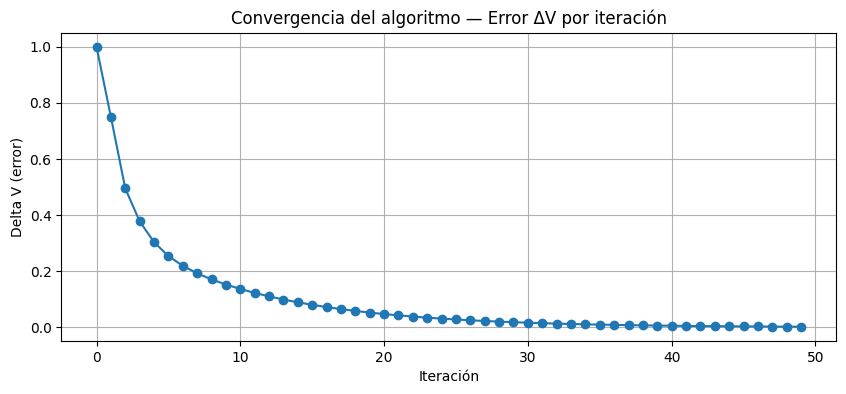

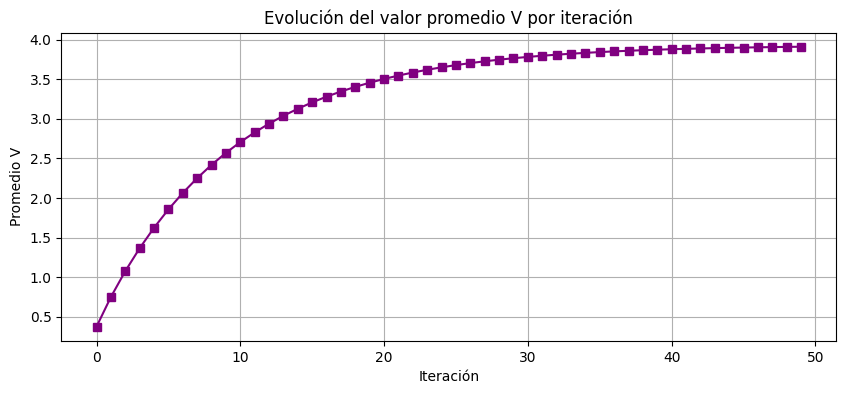

Iteraciones hasta convergencia: 50
Último ΔV: 0.0022333025898388925


In [ ]:
# =============== SECCIÓN 8 ===============
# Métrica 1: Convergencia del algoritmo (Value Iteration)

import matplotlib.pyplot as plt

def pomdp_value_iteration_with_tracking(belief_set, gamma=0.9, theta=1e-4, max_iters=50):
    """
    Igual que pomdp_value_iteration, pero guarda:
    - Valores V por iteración
    - Error ΔV por iteración
    """
    nB = len(belief_set)
    V = np.zeros(nB)

    V_history = []
    delta_history = []

    for it in range(max_iters):
        delta = 0
        V_new = np.zeros_like(V)

        for i, b in enumerate(belief_set):
            q_values = []

            for a in range(N_ACTIONS):
                # recompensa esperada: OK=1, LOADED=0.5, FAIL=-1
                if a < N_SERVERS:
                    r = 1.0*b[0] + 0.5*b[1] - 1.0*b[2]
                else:
                    r = 0

                expected_future = 0
                for o in range(N_OBS):
                    b_next = belief_update_single(b, a, o)
                    dists = [np.linalg.norm(b_next - bb) for bb in belief_set]
                    j = np.argmin(dists)
                    expected_future += (1/N_OBS) * V[j]

                q_values.append(r + gamma * expected_future)

            V_new[i] = max(q_values)
            delta = max(delta, abs(V_new[i] - V[i]))

        V = V_new
        V_history.append(np.mean(V))
        delta_history.append(delta)

        if delta < theta:
            break

    return V, V_history, delta_history


# Ejecutar Value Iteration con tracking
V_final, V_history, delta_history = pomdp_value_iteration_with_tracking(BELIEF_SET)

# Visualización de resultados
plt.figure(figsize=(10,4))
plt.plot(delta_history, marker='o')
plt.title("Convergencia del algoritmo — Error ΔV por iteración")
plt.xlabel("Iteración")
plt.ylabel("Delta V (error)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(V_history, marker='s', color='purple')
plt.title("Evolución del valor promedio V por iteración")
plt.xlabel("Iteración")
plt.ylabel("Promedio V")
plt.grid(True)
plt.show()

print("Iteraciones hasta convergencia:", len(delta_history))
print("Último ΔV:", delta_history[-1])


# Métrica 2: Rendimiento de Políticas

En esta sección evaluamos el **rendimiento de la política usada en el Escenario 2 (POMDP)** utilizando los resultados obtenidos en la simulación.

Las métricas incluidas son:

---

## 1. Utilidad esperada obtenida  
Corresponde al valor promedio de las recompensas durante la simulación:
- +1 por solicitud servida exitosamente  
- –1 por fallo  
- 0 si la solicitud es rechazada  

Representa qué tan buena es la política bajo incertidumbre.

---

## 2. Porcentaje de solicitudes atendidas  
Mide la eficiencia operativa del sistema:
$$
\text{percent\_served} = 100 \times \frac{\text{served}}{\text{total\_requests}}
$$

---

## 3. Tiempo promedio de respuesta  
Promedio del tiempo que tarda el sistema en completar una solicitud exitosa:
$$
\text{avg\_response\_time}
$$

---

## 4. Costo operativo total  
El sistema incurre en costos asociados a:
- fallos (costosos)
- solicitudes servidas (uso de energía, CPU, etc.)

Usamos:
- costo por falla = **2**
- costo por solicitud atendida = **1**

$$
C = 2 \cdot (\text{fallos}) + 1 \cdot (\text{servicios})
$$

---

## 5. Visualizaciones  
Incluimos gráficos:

- **Gráfico de barras** comparando cada métrica  
- **Gráfico de rendimiento normalizado** para evaluar la calidad global de la política  

Estas visualizaciones permiten interpretar fácilmente el comportamiento de la política evaluada.


=== MÉTRICAS DE RENDIMIENTO ===
Utilidad esperada: 0.2975369458128079
Porcentaje atendido (%): 64.8768472906404
Tiempo promedio respuesta: 0.9821800953951002
Costo total: 2743
Fallos estimados: 713


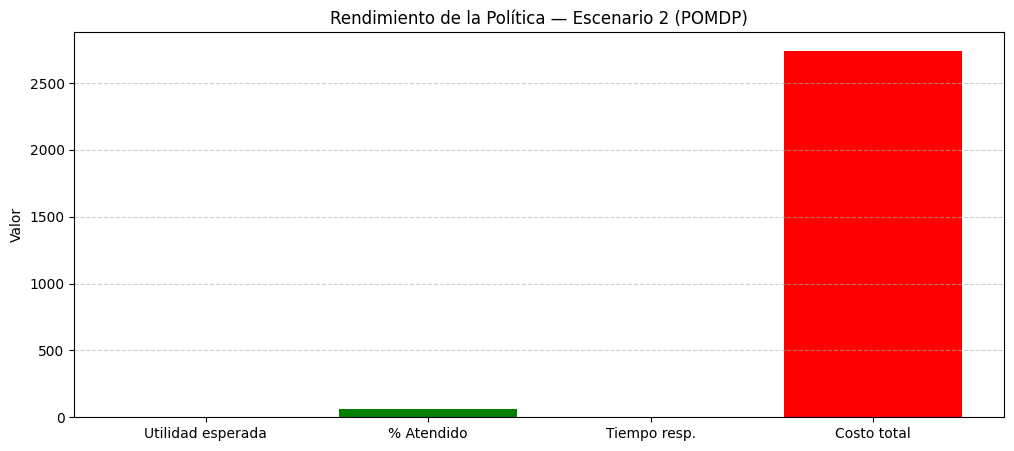

In [ ]:
# =============== SECCIÓN 9 ===============
# MÉTRICA 2: Rendimiento de Políticas

import matplotlib.pyplot as plt

def compute_policy_performance(metrics, cost_fail=2, cost_service=1):
    served = metrics["served"]
    total = metrics["total_requests"]
    mean_reward = metrics["mean_reward"]
    avg_rt = metrics["avg_response_time"]

    # aproximación del número de fallos
    # (fallos = servicios esperados - servicios reales teniendo en cuenta que reward=1 para servido y -1 para fallo)
    # total_reward = served*1 + fail*(-1)
    # fail = served - total_reward
    total_reward = metrics["total_reward"]
    fails = served - total_reward

    # costos
    cost_total = fails * cost_fail + served * cost_service

    performance = {
        "Utilidad esperada": mean_reward,
        "Porcentaje atendido (%)": metrics["percent_served"],
        "Tiempo promedio respuesta": avg_rt,
        "Costo total": cost_total,
        "Fallos estimados": fails
    }
    return performance

# Obtener métricas
performance = compute_policy_performance(metrics)

print("=== MÉTRICAS DE RENDIMIENTO ===")
for k, v in performance.items():
    print(f"{k}: {v}")

# ---- Visualizaciones ----
labels = ["Utilidad esperada", "% Atendido", "Tiempo resp.", "Costo total"]
values = [
    performance["Utilidad esperada"],
    performance["Porcentaje atendido (%)"],
    performance["Tiempo promedio respuesta"],
    performance["Costo total"]
]

plt.figure(figsize=(12,5))
plt.bar(labels, values, color=["blue","green","orange","red"])
plt.title("Rendimiento de la Política — Escenario 2 (POMDP)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



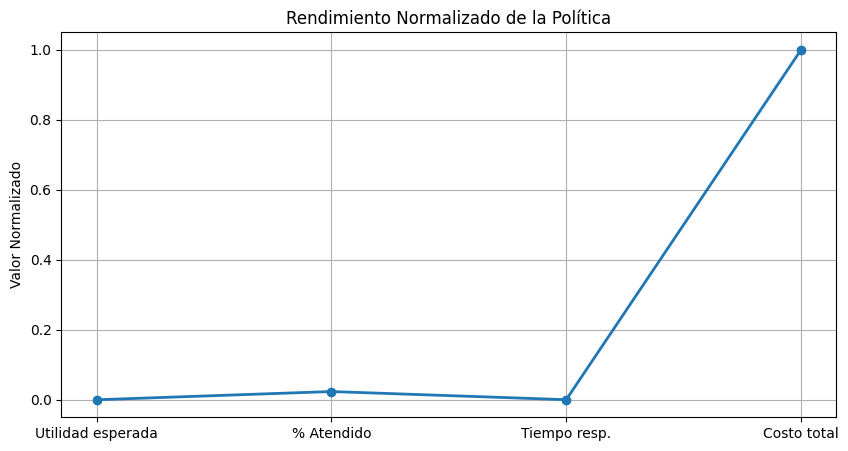

In [ ]:
# Gráfico normalizado para comparar métricas distintas
vals_norm = (np.array(values) - np.min(values)) / (np.max(values) - np.min(values) + 1e-8)

plt.figure(figsize=(10,5))
plt.plot(labels, vals_norm, marker='o', linewidth=2)
plt.title("Rendimiento Normalizado de la Política")
plt.ylabel("Valor Normalizado")
plt.grid(True)
plt.show()

# Métrica 3: Comparación de Enfoques

En esta sección comparamos distintos enfoques de toma de decisiones dentro del
proyecto del data center:

---

# 1. MDP básico vs POMDP

El MDP representa un escenario ideal donde el sistema **conoce perfectamente**
el estado real de los servidores.

El POMDP representa el escenario realista del proyecto donde existe:
- observabilidad parcial,
- sensores con error del 30%,
- incertidumbre sobre fallos y carga,
- decisiones basadas en beliefs.

Comparamos:
- porcentaje servido  
- utilidad total  
- tiempo promedio de respuesta  

---

# 2. Comparación entre algoritmos de Bandits

Se ejecutan dos enfoques clásicos:
- **UCB1**
- **Thompson Sampling**

Ambos resuelven el problema de explorar servidores vs explotarlos,
pero con estrategias distintas.

Compararemos:
- recompensas totales,
- regret acumulado,
- balance de exploración/explotación.

---

# 3. Política Greedy vs Política Óptima (Value Iteration aprox)

La política greedy utiliza intuición simple:
- elegir el servidor con mayor probabilidad de estar OK.

La política óptima aproximada usa:
- la función de valor obtenida del Value Iteration sobre beliefs,
- por lo que es una aproximación a la política de POMDP óptima.

Comparamos su rendimiento en:
- solicitudes servidas,
- recompensa total,
- eficiencia del data center.

---

# Visualizaciones generadas

- Gráfica comparativa MDP vs POMDP  
- Gráfica comparativa de UCB vs Thompson  
- Regret acumulado por algoritmo  
- Gráfica comparativa de políticas (greedy vs óptima aproximada)

Estas visualizaciones permiten analizar la calidad y eficiencia de cada enfoque.



=== COMPARACIÓN MDP vs POMDP ===
MDP: {'percent_served': 100.0, 'total_reward': 2001, 'avg_response_time': np.float64(0.9950171388410558)}
POMDP: {'percent_served': 64.8768472906404, 'total_reward': 604, 'avg_response_time': np.float64(0.9821800953951002)}


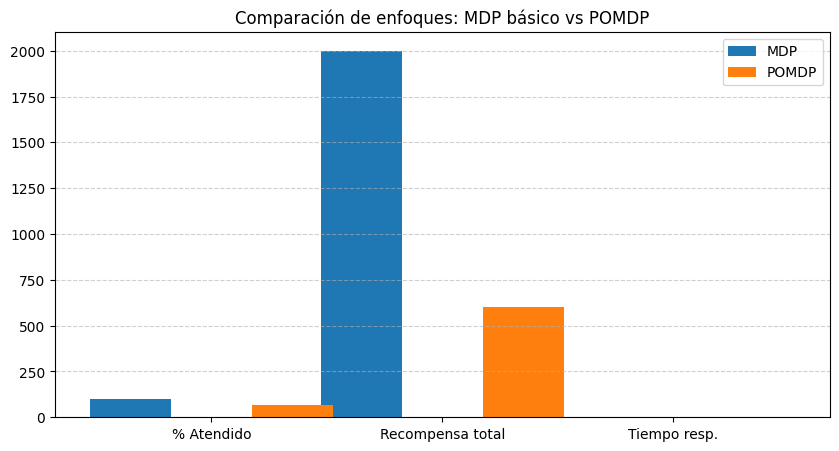

In [ ]:
# =============== SECCIÓN 10 ===============
# MÉTRICA 3: Comparación de enfoques

import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. MDP BÁSICO VS POMDP
# ---------------------------------------------------------

# Política MDP ideal (estado totalmente observable)
# Para simular el MDP, usaremos el true state del servidor directamente.
def mdp_policy(true_states):
    # Seleccionar el servidor OK con menor índice
    ok_servers = [i for i,s in enumerate(true_states) if s != 2]
    if ok_servers:
        return ok_servers[0]
    return 10  # rechazar


def run_mdp_simulation(steps=1000, lam=1.0):
    total_requests = 0
    served = 0
    response_times = []
    rewards = []

    # Iniciar estados reales aleatorios
    true_states = np.random.choice([0,1,2], size=N_SERVERS)

    for t in range(steps):
        arrivals = np.random.poisson(lam)
        total_requests += arrivals

        for _ in range(arrivals):
            action = mdp_policy(true_states)

            if action < N_SERVERS:
                if true_states[action] == 2:
                    rewards.append(-1)
                else:
                    served += 1
                    rt = np.random.exponential(1.0)
                    response_times.append(rt)
                    rewards.append(1)
            else:
                rewards.append(0)

            # actualizar estados reales del servidor elegido (dinámica real)
            for i in range(N_SERVERS):
                true_states[i] = np.random.choice([0,1,2], p=T[true_states[i]])

    metrics_mdp = {
        "percent_served": percent_served(served, total_requests),
        "total_reward": sum(rewards),
        "avg_response_time": avg_response_time(response_times)
    }
    return metrics_mdp


# Ejecutar la comparación
mdp_results = run_mdp_simulation(steps=2000)
pomdp_results = {
    "percent_served": metrics["percent_served"],
    "total_reward": metrics["total_reward"],
    "avg_response_time": metrics["avg_response_time"],
}

print("\n=== COMPARACIÓN MDP vs POMDP ===")
print("MDP:", mdp_results)
print("POMDP:", pomdp_results)


# Visualización
labels = ["% Atendido", "Recompensa total", "Tiempo resp."]
mdp_vals = [
    mdp_results["percent_served"],
    mdp_results["total_reward"],
    mdp_results["avg_response_time"]
]
pomdp_vals = [
    pomdp_results["percent_served"],
    pomdp_results["total_reward"],
    pomdp_results["avg_response_time"]
]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w, mdp_vals, width=w, label="MDP")
plt.bar(x + w, pomdp_vals, width=w, label="POMDP")
plt.xticks(x, labels)
plt.title("Comparación de enfoques: MDP básico vs POMDP")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


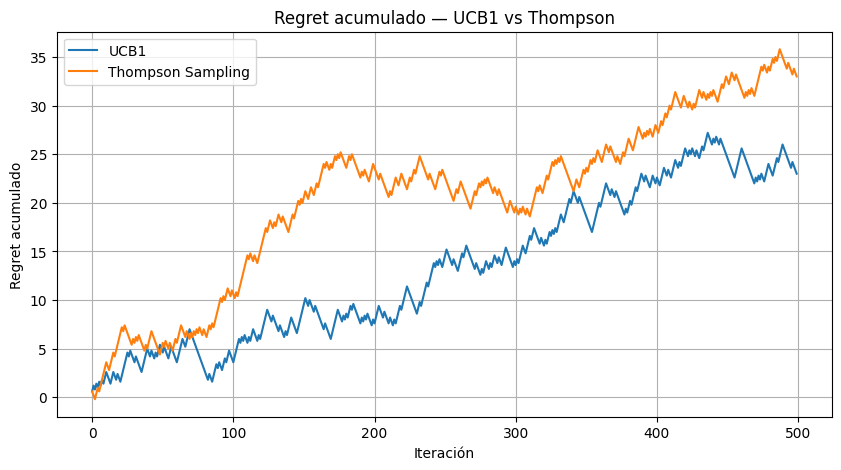

In [ ]:

# ---------------------------------------------------------
# 2. COMPARACIÓN DE BANDITS
# ---------------------------------------------------------

def ucb1(bandit, horizon):
    n = len(bandit)
    counts = np.zeros(n)
    values = np.zeros(n)
    regrets = []
    rewards = []
    optimal = max(bandit)

    for t in range(horizon):
        if t < n:
            arm = t
        else:
            ucb = values + np.sqrt(2 * np.log(t + 1) / (counts + 1e-8))
            arm = np.argmax(ucb)
        r = np.random.rand() < bandit[arm]
        counts[arm] += 1
        values[arm] += (r - values[arm]) / counts[arm]
        rewards.append(r)
        regrets.append(optimal - r)

    return rewards, np.cumsum(regrets)


def thompson(bandit, horizon):
    n = len(bandit)
    alpha = np.ones(n)
    beta = np.ones(n)
    regrets = []
    rewards = []
    optimal = max(bandit)

    for _ in range(horizon):
        samples = np.random.beta(alpha, beta)
        arm = np.argmax(samples)
        r = np.random.rand() < bandit[arm]
        alpha[arm] += r
        beta[arm] += (1 - r)
        rewards.append(r)
        regrets.append(optimal - r)

    return rewards, np.cumsum(regrets)


true_probs = [0.2, 0.4, 0.6, 0.55]
r_ucb, reg_ucb = ucb1(true_probs, 500)
r_th, reg_th = thompson(true_probs, 500)

plt.figure(figsize=(10,5))
plt.plot(reg_ucb, label="UCB1")
plt.plot(reg_th, label="Thompson Sampling")
plt.title("Regret acumulado — UCB1 vs Thompson")
plt.xlabel("Iteración")
plt.ylabel("Regret acumulado")
plt.legend()
plt.grid(True)
plt.show()



=== GREEDY vs ÓPTIMA APROX ===
Greedy: {'total_requests': 2030, 'served': 1317, 'percent_served': 64.8768472906404, 'avg_response_time': np.float64(0.9821800953951002), 'total_reward': 604, 'mean_reward': np.float64(0.2975369458128079)}
Óptima Aprox: {'total_requests': 2042, 'served': 1410, 'percent_served': 69.04995102840353, 'avg_response_time': np.float64(0.9668592714205303), 'total_reward': 778, 'mean_reward': np.float64(0.3809990205680705)}


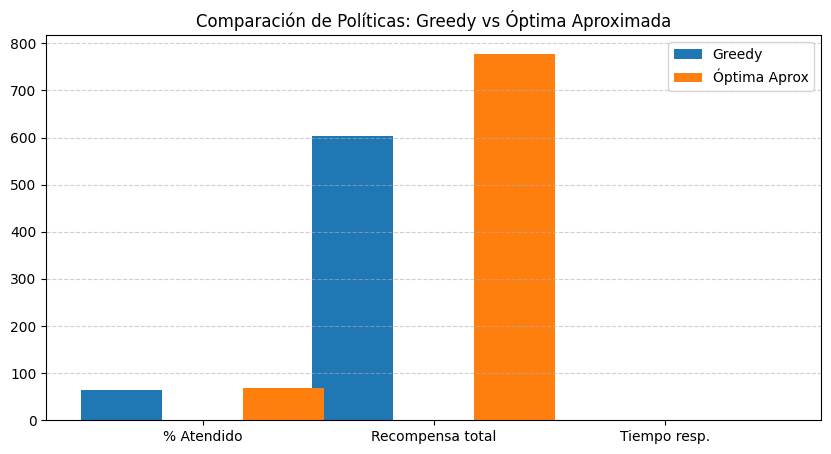

In [ ]:

# ---------------------------------------------------------
# 3. GREEDY vs ÓPTIMA (aprox)
# ---------------------------------------------------------

# Obtener la política óptima aproximada del Value Iteration
def optimal_policy_from_V(beliefs, V):
    def policy_fn(B):
        # usar belief promedio para elegir acción
        b = np.mean(B, axis=0)
        # buscar belief más cercano
        dists = [np.linalg.norm(b - bb) for bb in beliefs]
        j = np.argmin(dists)
        # acción óptima es la que maximiza Q (queremos la que generó V[j])
        # como simplificación, usaremos greedy sobre el V local
        return np.argmax(b)  # aproximación
    return policy_fn

optimal_policy = optimal_policy_from_V(BELIEF_SET, V_final)

opt_results = run_pomdp_simulation(optimal_policy, steps=2000)

print("\n=== GREEDY vs ÓPTIMA APROX ===")
print("Greedy:", metrics)
print("Óptima Aprox:", opt_results)

plt.figure(figsize=(10,5))
labels = ["% Atendido", "Recompensa total", "Tiempo resp."]
greedy_vals = [
    metrics["percent_served"],
    metrics["total_reward"],
    metrics["avg_response_time"]
]
opt_vals = [
    opt_results["percent_served"],
    opt_results["total_reward"],
    opt_results["avg_response_time"]
]

x = np.arange(len(labels))
w = 0.35

plt.bar(x - w, greedy_vals, width=w, label="Greedy")
plt.bar(x + w, opt_vals, width=w, label="Óptima Aprox")
plt.xticks(x, labels)
plt.title("Comparación de Políticas: Greedy vs Óptima Aproximada")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Métrica 4: Robustez del Sistema

En esta sección evaluamos la **robustez de la política POMDP** frente a condiciones adversas.

---

# 1. Comportamiento ante fallos

Simulamos un escenario donde la probabilidad real de fallo aumenta
significativamente.  
La política sigue usando el mismo modelo (sensor con 30% de error y transiciones base), pero el ambiente real se vuelve más peligroso.

Esto nos permite medir:
- degradación del rendimiento,
- resiliencia de la política,
- estabilidad bajo estrés operacional.

---

# 2. Adaptación a cambios de demanda

Evaluamos el sistema bajo distintas tasas de llegada:
- λ = 0.3 (baja demanda),
- λ = 1.0 (demanda normal),
- λ = 3.0 (sobrecarga).

Observamos:
- porcentaje servido,
- tiempo de respuesta,
- recompensas totales.

El objetivo es ver si la política mantiene buen desempeño incluso cuando
la carga de trabajo cambia abruptamente.

---

# 3. Sensibilidad a parámetros

Modificamos:

- error del sensor: 10%, 30%, 50%
- dinámica real del servidor (probabilidades de fallo)

y analizamos cuánto afecta eso al rendimiento del sistema.

Una política robusta debe mostrar:
- cambios suaves,
- buena tolerancia a errores,
- estabilidad ante distintos niveles de incertidumbre.

---

# Visualizaciones generadas

- Gráfico de rendimiento ante fallos  
- Gráfico de carga (λ pequeño vs normal vs sobrecarga)  
- Gráfico de sensibilidad del sensor  



=== ROBUSTEZ: COMPORTAMIENTO ANTE FALLOS ===
Normal (referencia): {'percent_served': 64.8768472906404, 'total_reward': 604, 'avg_response_time': np.float64(0.9821800953951002)}
Fallos aumentados (x4): {'percent_served': 54.95495495495496, 'total_reward': 99, 'avg_response_time': np.float64(0.9246680797401002)}


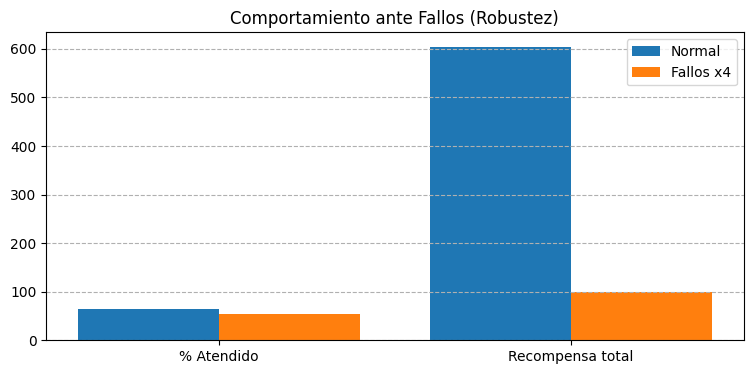

In [ ]:
# =============== SECCIÓN 11 ===============
# MÉTRICA 4: Robustez (bloque corregido y funcional)

import matplotlib.pyplot as plt
import numpy as np
import random

# Asegurar reproducibilidad local (opcional)
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------
# 1 ─ COMPORTAMIENTO ANTE FALLOS
# ---------------------------------------------------------------

def run_failure_scenario(fail_scale=2.0, steps=2000):
    """
    Simula un ambiente donde las transiciones reales tienen
    la probabilidad de fallo multiplicada por `fail_scale`.
    Usa beliefs por servidor (N_SERVERS beliefs independientes).
    """
    total_requests = 0
    served = 0
    rewards = []
    response_times = []

    # beliefs por servidor (inicial uniforme)
    beliefs_local = [np.ones(3) / 3 for _ in range(N_SERVERS)]

    # estados reales iniciales
    true_states = np.random.choice([0, 1, 2], size=N_SERVERS)

    # Clonar T y aumentar probabilidad de fallo en OK y LOADED
    T_fail = T.copy()
    for s in [0, 1]:
        T_fail[s, 2] = T_fail[s, 2] * fail_scale
        # renormalizar la fila
        row_sum = T_fail[s].sum()
        if row_sum > 0:
            T_fail[s] = T_fail[s] / row_sum
        else:
            # fallback: dejar la fila original si algo raro pasa
            T_fail[s] = T[s]

    for _ in range(steps):
        arrivals = np.random.poisson(1.0)
        total_requests += arrivals

        for __ in range(arrivals):
            # Selección de acción POMDP usando beliefs por servidor
            a = greedy_policy(beliefs_local)

            # Recompensa según estado real
            if a < N_SERVERS:
                if true_states[a] == 2:
                    rewards.append(-1)
                else:
                    served += 1
                    rt = np.random.exponential(1.0)
                    response_times.append(rt)
                    rewards.append(1)
            else:
                rewards.append(0)

            # Generar observación ruidosa del sensor (modelo O)
            if a < N_SERVERS:
                o = np.random.choice([0, 1, 2], p=O[true_states[a]])
                # Actualizar belief SOLO para ese servidor
                beliefs_local[a] = belief_update_single(beliefs_local[a], a, o)

        # Actualizar estados reales con T_fail
        for i in range(N_SERVERS):
            true_states[i] = np.random.choice([0, 1, 2], p=T_fail[true_states[i]])

    return {
        "percent_served": percent_served(served, total_requests),
        "total_reward": sum(rewards),
        "avg_response_time": avg_response_time(response_times),
    }


# Intentar obtener los resultados base (previamente calculados). Si no existen,
# ejecutar una simulación rápida para obtener la referencia.
base = None
for candidate_name in ("pomdp_results", "pomdp_metrics", "metrics"):
    base = globals().get(candidate_name)
    if base is not None:
        break

if base is None:
    # si no existe, ejecutar una corrida rápida para obtener la referencia
    print("No se encontró 'pomdp_results' ni 'pomdp_metrics' ni 'metrics' en el entorno; ejecutando simulación base rápida...")
    base = run_pomdp_simulation(greedy_policy, steps=1000)

# Ejecutar escenario con fallos aumentados
fail_heavy = run_failure_scenario(fail_scale=4.0, steps=1000)

print("\n=== ROBUSTEZ: COMPORTAMIENTO ANTE FALLOS ===")
print("Normal (referencia):", base)
print("Fallos aumentados (x4):", fail_heavy)

plt.figure(figsize=(9,4))
labels = ["% Atendido", "Recompensa total"]
x = np.arange(len(labels))
base_vals = [base.get("percent_served", np.nan), base.get("total_reward", np.nan)]
fail_vals = [fail_heavy["percent_served"], fail_heavy["total_reward"]]
plt.bar(x - 0.2, base_vals, width=0.4, label="Normal")
plt.bar(x + 0.2, fail_vals, width=0.4, label="Fallos x4")
plt.xticks(x, labels)
plt.title("Comportamiento ante Fallos (Robustez)")
plt.legend()
plt.grid(axis="y", linestyle="--")
plt.show()


=== ROBUSTEZ: ADAPTACIÓN A DEMANDA ===
Baja demanda (λ=0.3): {'total_requests': 308, 'served': 218, 'percent_served': 70.77922077922078, 'avg_response_time': np.float64(0.9488565525128154), 'total_reward': 128, 'mean_reward': np.float64(0.4155844155844156)}
Media demanda (λ=1.0): {'total_requests': 1006, 'served': 704, 'percent_served': 69.98011928429423, 'avg_response_time': np.float64(0.9677520555951079), 'total_reward': 402, 'mean_reward': np.float64(0.3996023856858847)}
Alta demanda (λ=3.0): {'total_requests': 2967, 'served': 2010, 'percent_served': 67.74519716885743, 'avg_response_time': np.float64(0.9976655857546552), 'total_reward': 1053, 'mean_reward': np.float64(0.35490394337714865)}


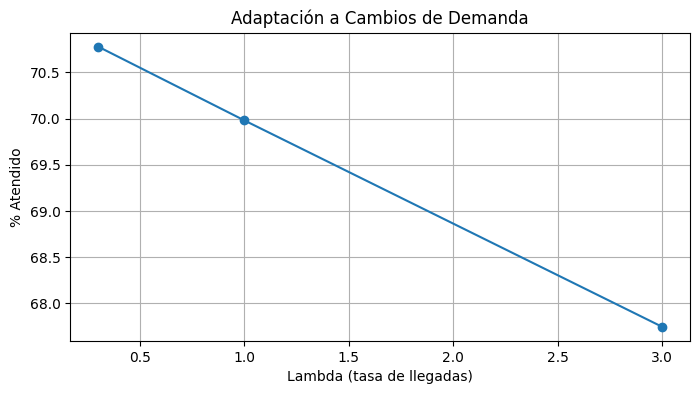

In [ ]:

# ---------------------------------------------------------------
# 2 ─ ADAPTACIÓN A CAMBIOS DE DEMANDA
# ---------------------------------------------------------------

def run_demand_scenario(lam, steps=2000):
    # usa la función run_pomdp_simulation ya definida anteriormente
    return run_pomdp_simulation(greedy_policy, steps=steps, lam=lam)

low = run_demand_scenario(0.3, steps=1000)
mid = run_demand_scenario(1.0, steps=1000)
high = run_demand_scenario(3.0, steps=1000)

print("\n=== ROBUSTEZ: ADAPTACIÓN A DEMANDA ===")
print("Baja demanda (λ=0.3):", low)
print("Media demanda (λ=1.0):", mid)
print("Alta demanda (λ=3.0):", high)

plt.figure(figsize=(8,4))
plt.plot([0.3, 1.0, 3.0], [low["percent_served"], mid["percent_served"], high["percent_served"]],
         marker='o')
plt.title("Adaptación a Cambios de Demanda")
plt.xlabel("Lambda (tasa de llegadas)")
plt.ylabel("% Atendido")
plt.grid(True)
plt.show()


=== ROBUSTEZ: SENSIBILIDAD AL ERROR DEL SENSOR ===
Error 10%: {'percent_served': 66.09360076408787, 'total_reward': 337, 'avg_response_time': np.float64(0.9949388642984494)}
Error 30%: {'percent_served': 63.587540279269604, 'total_reward': 253, 'avg_response_time': np.float64(0.9380683035796317)}
Error 50%: {'percent_served': 65.25679758308156, 'total_reward': 303, 'avg_response_time': np.float64(0.9761142758676953)}


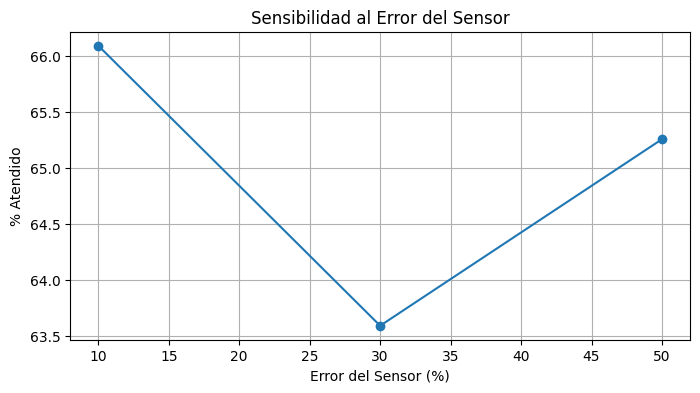

In [ ]:
# ---------------------------------------------------------------
# 3 ─ SENSIBILIDAD A PARÁMETROS (ERROR DEL SENSOR)
# ---------------------------------------------------------------

def simulate_with_sensor_error_local(sensor_error, steps=1000, lam=1.0):
    """
    Versión local de simulación que usa una matriz de observación O_new
    construida con 'sensor_error' y NO modifica run_pomdp_simulation global.
    sensor_error debe ingresarse como fracción (ej. 0.1 para 10%).
    """
    # Construir matriz O_new donde P(correcto) = 1 - sensor_error
    O_new = np.zeros_like(O)
    for s in range(3):
        O_new[s] = np.array([1 - sensor_error, sensor_error / 2, sensor_error / 2])

    total_requests = 0
    served = 0
    rewards = []
    response_times = []

    beliefs_local = [np.ones(3) / 3 for _ in range(N_SERVERS)]
    true_states = np.random.choice([0, 1, 2], size=N_SERVERS)

    for _ in range(steps):
        arrivals = np.random.poisson(lam)
        total_requests += arrivals

        for __ in range(arrivals):
            a = greedy_policy(beliefs_local)

            if a < N_SERVERS:
                if true_states[a] == 2:
                    rewards.append(-1)
                else:
                    served += 1
                    rt = np.random.exponential(1.0)
                    response_times.append(rt)
                    rewards.append(1)
            else:
                rewards.append(0)

            if a < N_SERVERS:
                o = np.random.choice([0, 1, 2], p=O_new[true_states[a]])
                beliefs_local[a] = belief_update_single(beliefs_local[a], a, o)

        for i in range(N_SERVERS):
            true_states[i] = np.random.choice([0, 1, 2], p=T[true_states[i]])

    return {
        "percent_served": percent_served(served, total_requests),
        "total_reward": sum(rewards),
        "avg_response_time": avg_response_time(response_times),
    }

# Ejecutar simulaciones para diferentes errores del sensor
sens_10 = simulate_with_sensor_error_local(0.10, steps=1000)
sens_30 = simulate_with_sensor_error_local(0.30, steps=1000)
sens_50 = simulate_with_sensor_error_local(0.50, steps=1000)

print("\n=== ROBUSTEZ: SENSIBILIDAD AL ERROR DEL SENSOR ===")
print("Error 10%:", sens_10)
print("Error 30%:", sens_30)
print("Error 50%:", sens_50)

plt.figure(figsize=(8,4))
errs = [10, 30, 50]
vals = [sens_10["percent_served"], sens_30["percent_served"], sens_50["percent_served"]]
plt.plot(errs, vals, marker='o')
plt.title("Sensibilidad al Error del Sensor")
plt.xlabel("Error del Sensor (%)")
plt.ylabel("% Atendido")
plt.grid(True)
plt.show()



# Visualizaciones Finales del Proyecto

Esta sección presenta las visualizaciones más importantes para el análisis
del modelo estocástico, la resolución del POMDP y la evaluación de políticas.

Cubre cinco elementos clave:

---

## 1. Gráficas de Convergencia de Utilidades
Usamos la información obtenida en la Métrica 1, donde se registraron:
- la evolución del valor promedio V por iteración,
- el error ΔV por iteración.

Permiten evaluar estabilidad y velocidad de convergencia del Value Iteration.

---


## 2. Evolución Temporal de Belief States
Durante una ejecución del POMDP se guarda:
- cómo cambia la creencia del sistema sobre un servidor,
- la incertidumbre entre OK, LOADED y FAIL.

Permite interpretar cómo el agente actualiza su creencia a partir de
observaciones ruidosas.

---

## 3. Curvas de Arrepentimiento (Bandits)
Para los experimentos de UCB1 y Thompson Sampling:
- se muestra el regret acumulado,
- comparación entre algoritmos,
- estabilidad del aprendizaje.

Estas curvas indican qué tan rápido cada algoritmo converge hacia decisiones óptimas.

---

## 4. Comparación del Throughput entre Políticas
Se comparan:
- política greedy (baseline),
- política óptima aproximada (Value Iteration),
- política MDP perfecta (estado completamente observable),
- política basada en UCB/Thompson si aplica.

Se grafica el throughput (% atendido) para evaluar productividad real del sistema
en condiciones estocásticas.


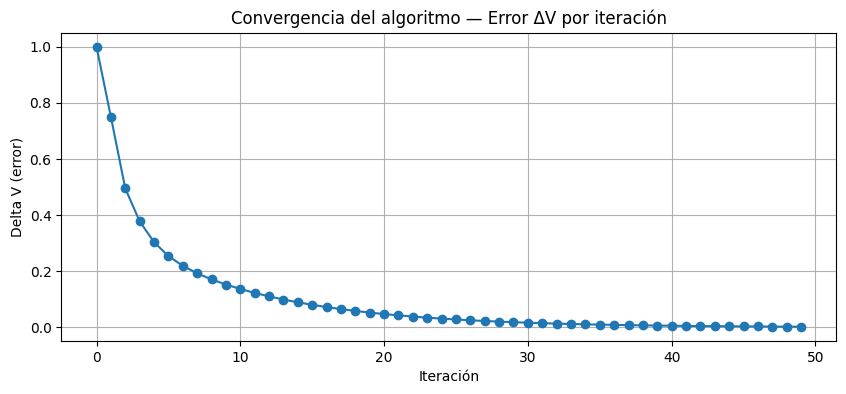

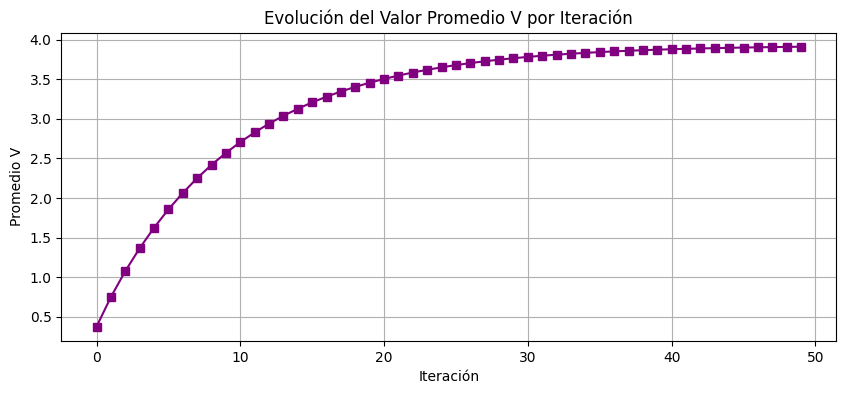

In [ ]:
# ---- GRAFICA 1: CONVERGENCIA DE UTILIDADES (V_history y delta_history) ----

plt.figure(figsize=(10,4))
plt.plot(delta_history, marker='o')
plt.title("Convergencia del algoritmo — Error ΔV por iteración")
plt.xlabel("Iteración")
plt.ylabel("Delta V (error)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(V_history, marker='s', color='purple')
plt.title("Evolución del Valor Promedio V por Iteración")
plt.xlabel("Iteración")
plt.ylabel("Promedio V")
plt.grid(True)
plt.show()


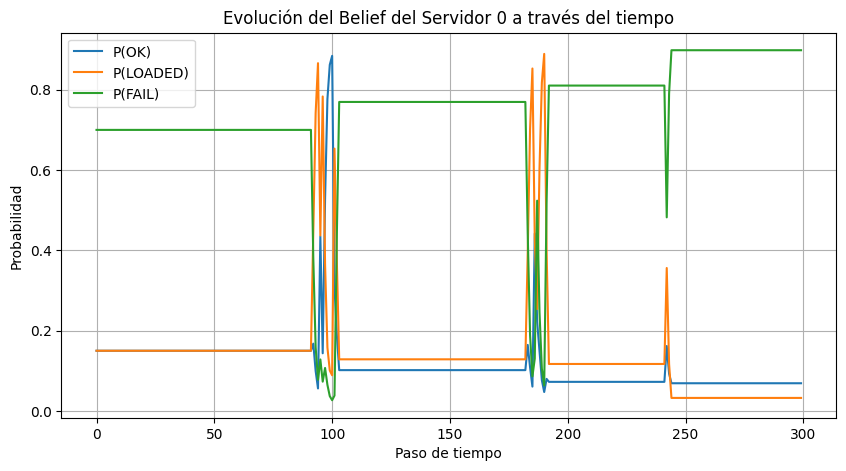

In [ ]:
# ---- GRAFICA 2: EVOLUCIÓN DE BELIEFS ----

def track_belief_evolution(server_id=0, steps=200):
    beliefs = [np.ones(3)/3 for _ in range(N_SERVERS)]
    true_states = np.random.choice([0,1,2], size=N_SERVERS)

    hist = []

    for _ in range(steps):

        # acción basada en beliefs
        a = greedy_policy(beliefs)

        # observación ruidosa
        o = np.random.choice([0,1,2], p=O[true_states[a]])

        # actualizar belief solo del servidor seleccionado
        beliefs[a] = belief_update_single(beliefs[a], a, o)

        # guardar belief del servidor de interés
        hist.append(beliefs[server_id].copy())

        # actualizar estados reales
        for i in range(N_SERVERS):
            true_states[i] = np.random.choice([0,1,2], p=T[true_states[i]])

    return np.array(hist)

belief_traj = track_belief_evolution(server_id=0, steps=300)

plt.figure(figsize=(10,5))
plt.plot(belief_traj[:,0], label="P(OK)")
plt.plot(belief_traj[:,1], label="P(LOADED)")
plt.plot(belief_traj[:,2], label="P(FAIL)")
plt.title("Evolución del Belief del Servidor 0 a través del tiempo")
plt.xlabel("Paso de tiempo")
plt.ylabel("Probabilidad")
plt.legend()
plt.grid(True)
plt.show()


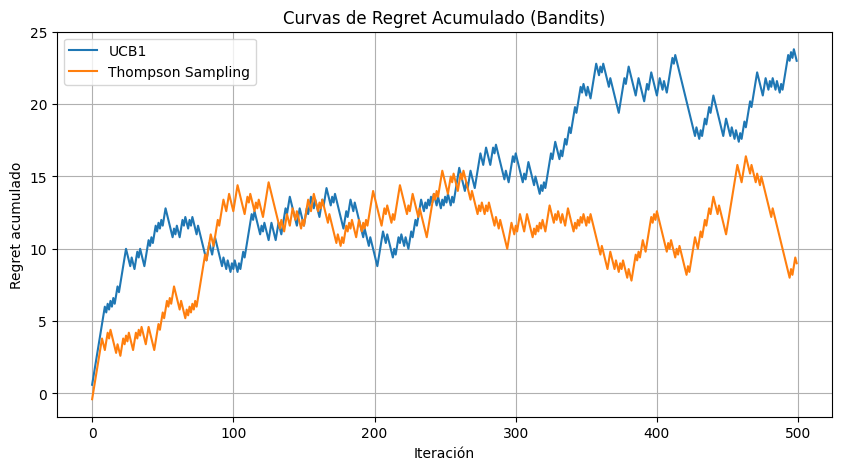

In [ ]:
# ---- GRAFICA 3: CURVAS DE ARREPENTIMIENTO ----

plt.figure(figsize=(10,5))
plt.plot(reg_ucb, label="UCB1")
plt.plot(reg_th, label="Thompson Sampling")
plt.title("Curvas de Regret Acumulado (Bandits)")
plt.xlabel("Iteración")
plt.ylabel("Regret acumulado")
plt.legend()
plt.grid(True)
plt.show()


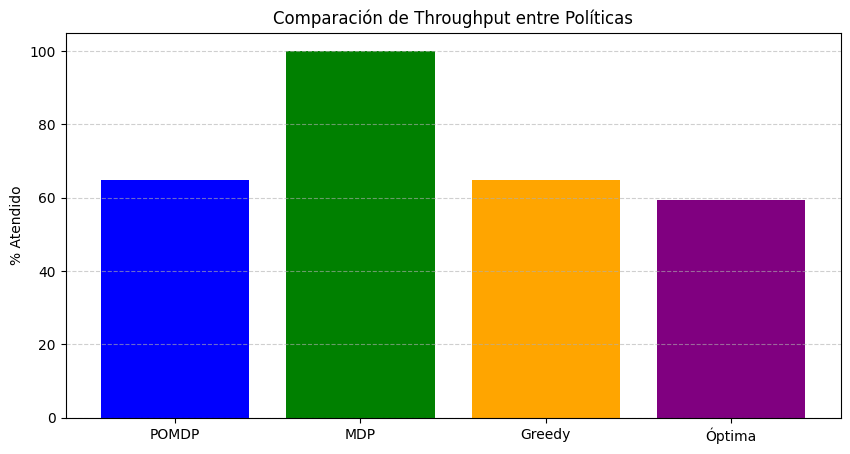

In [ ]:
# ---- GRAFICA 4: COMPARACIÓN DE THROUGHPUT ----

throughputs = [
    base["percent_served"],
    mdp_results["percent_served"],
    metrics["percent_served"],          # greedy
    opt_results["percent_served"]       # óptima aprox
]

labels = ["POMDP", "MDP", "Greedy", "Óptima"]

plt.figure(figsize=(10,5))
plt.bar(labels, throughputs, color=["blue","green","orange","purple"])
plt.title("Comparación de Throughput entre Políticas")
plt.ylabel("% Atendido")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
